Import + Prepare

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr
import lightgbm as lgb
import matplotlib.pyplot as plt
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error



# Load dataset
df = pd.read_csv('../data/target2_features.csv')

# Features and target
feature_cols = [col for col in df.columns if col not in ['date_id', 'target_2_shifted']]
X = df[feature_cols]
y = df['target_2_shifted']


Time-Aware Train/Test Split

In [2]:
# 80/20 time split
split_idx = int(len(df) * 0.8)

X_train, X_valid = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_valid = y.iloc[:split_idx], y.iloc[split_idx:]


Train LightGBM Regressor

In [3]:
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=500,
    learning_rate=0.03,
    max_depth=6,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',
    callbacks=[
        early_stopping(stopping_rounds=30),
        log_evaluation(period=50)
    ]
)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1180, number of used features: 11
[LightGBM] [Info] Start training from score 0.000069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.03
,n_estimators,500
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Evaluate + Interpret

In [4]:
# Predictions
y_pred = model.predict(X_valid)

# Metrics
r2 = r2_score(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = mse ** 0.5
spearman = spearmanr(y_valid, y_pred).correlation

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Spearman: {spearman:.4f}")



R²: -0.0017
MAE: 0.0090
RMSE: 0.0114
Spearman: 0.0115


Feature Importance

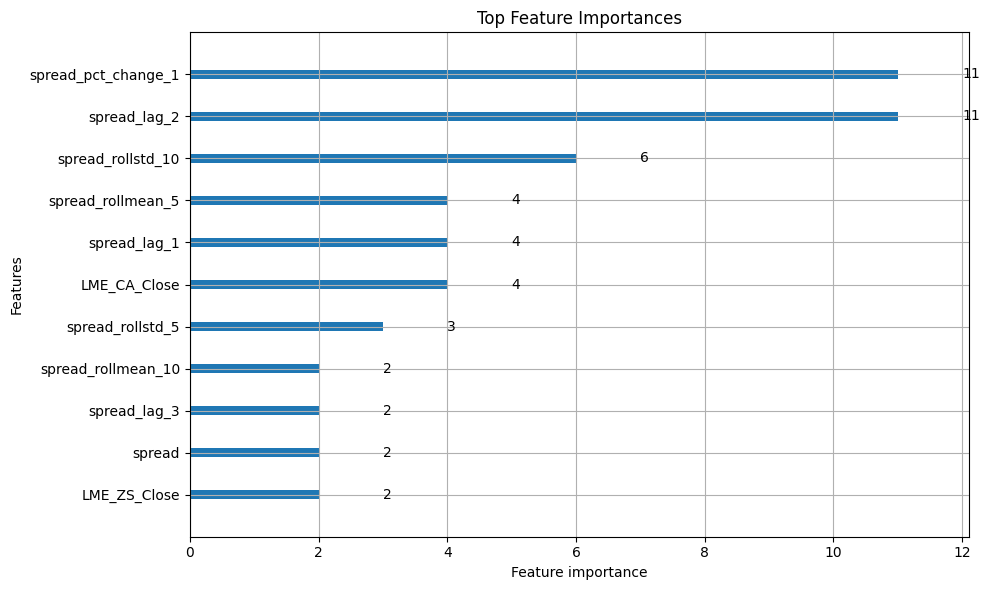

In [5]:
lgb.plot_importance(model, figsize=(10, 6), max_num_features=15)
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()


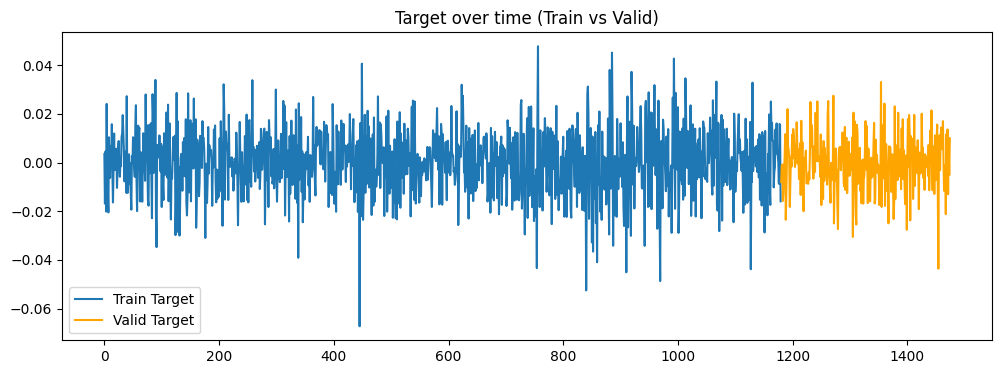

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(X_train.index, y_train, label='Train Target')
plt.plot(X_valid.index, y_valid, label='Valid Target', color='orange')
plt.legend()
plt.title("Target over time (Train vs Valid)")
plt.show()


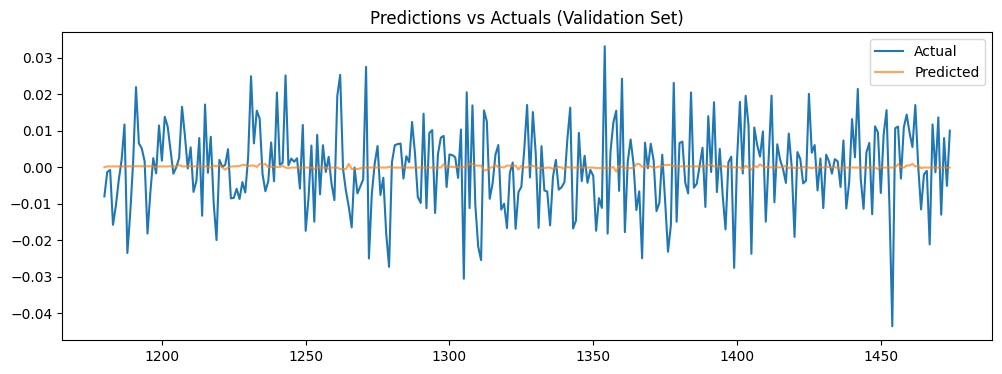

In [7]:
plt.figure(figsize=(12, 4))
plt.plot(y_valid.index, y_valid, label='Actual')
plt.plot(y_valid.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title("Predictions vs Actuals (Validation Set)")
plt.show()
